### Building a basic chatbot

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [2]:
class State(TypedDict):
    # messages have a type of list[str] and add the messages to the state
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)


In [3]:
graph_builder

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama-3.1-8b-instant")

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10612d5b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1078c4050>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [8]:
graph_builder = StateGraph(State)
graph_builder.add_node("llmchatbot", chatbot)

## START --> llmchatbot --> END
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)

# compile the graph
graph = graph_builder.compile()

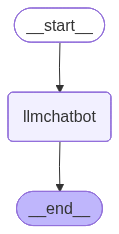

In [9]:
# visualize the graph
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [10]:
graph.invoke({"messages": ["Hello, how are you?"]})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='6db93264-5e40-402c-b08c-3db1173b5f69'),
  AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you have. How can I assist you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 41, 'total_tokens': 86, 'completion_time': 0.062943878, 'prompt_time': 0.002639862, 'queue_time': 0.077020139, 'total_time': 0.06558374}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4dea31877a', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--851faf09-9510-4aae-b67b-1795522779ee-0', usage_metadata={'input_tokens': 41, 'output_tokens': 45, 'total_tokens': 86})]}

In [11]:
for event in graph.stream({"messages": "Hi, how are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

I'm functioning properly, thank you for asking. How can I assist you today?


## Chatbot with Tool

In [12]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is LangGraph?")

{'query': 'What is LangGraph?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent interactio

In [13]:
## custom function

def multiply(a:int, b:int) -> int:
    """
    Multiplies a and b

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of a and b.
    """
    return a * b

In [14]:
tools = [tool, multiply]

In [15]:
llm_with_tool = llm.bind_tools(tools)

In [16]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x10612d5b0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x1078c4050>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domai

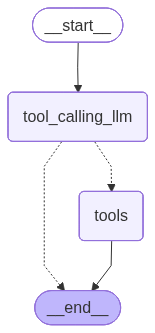

In [22]:
## Stategraph

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llms(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llms)
builder.add_node("tools", ToolNode(tools))

## Adding Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", 
                              # If the latest message (result) from the assistant is a tool call -> tools_condition routes to tools
                              # If the latest message (result) from the assistant is not a tool call -> tools_condition routes to END
                              tools_condition)


builder.add_edge("tools", END)


## compile the graph
graph_with_tool = builder.compile()

from IPython.display import display, Image
display(Image(graph_with_tool.get_graph().draw_mermaid_png()))

In [24]:
response = graph_with_tool.invoke({"messages": ["What is the recent ai news?"]})

In [25]:
response['messages'][-1].content

'{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/nasas-spacex-crew-11-makes-a-stellar-splash-at-the-iss", "title": "NASA\'s SpaceX Crew-11 Makes a Stellar Splash at the ISS! - OpenTools", "score": 0.8790744, "published_date": "Sun, 03 Aug 2025 09:12:52 GMT", "content": "Latest AI News: Daily Updated Artificial Intelligence Insights (August 3, 2025) Learn to use AI like a Pro. Learn More Latest AI News: August 3, 2025 Image 2: Mackenzie Ferguson ### Learn to use AI like a Pro Image 3: Canva Logo Image 4: Claude AI Logo Image 5: Google Gemini Logo Image 6: HeyGen Logo Image 7: Hugging Face Logo Image 8: Microsoft Logo Image 9: OpenAI Logo Image 10: Zapier Logo Image 11: Canva Logo Image 12: Claude AI Logo Image 13: Google Gemini Logo Image 14: HeyGen Logo Image 15: Hugging Face Logo Image 16: Microsoft Logo Image 17: OpenAI Logo Image 18: Zapier Logo *   New AI Tools *   Advertise with OpenTools *   Adv

In [30]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (c4mpx9wez)
 Call ID: c4mpx9wez
  Args:
    query: latest AI news
    start_date: 2024-01-01
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "latest AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/nasas-spacex-crew-11-makes-a-stellar-splash-at-the-iss", "title": "NASA's SpaceX Crew-11 Makes a Stellar Splash at the ISS! - OpenTools", "score": 0.8790744, "published_date": "Sun, 03 Aug 2025 09:12:52 GMT", "content": "Latest AI News: Daily Updated Artificial Intelligence Insights (August 3, 2025) Learn to use AI like a Pro. Learn More Latest AI News: August 3, 2025 Image 2: Mackenzie Ferguson ### Learn to use AI like a Pro Image 

In [ ]:
response2 = graph_with_tool.invoke({"messages": ["What is 12 multiplied by 15 then multiplied by 2?"]})

In [36]:
response2['messages'][-1].content

'360'

In [37]:
for m in response2['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 12 multiplied by 15 then multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (31cwq1s1f)
 Call ID: 31cwq1s1f
  Args:
    a: 12
    b: 15
  multiply (1ayxreytq)
 Call ID: 1ayxreytq
  Args:
    a: 180
    b: 2
================================= Tool Message =================================
Name: multiply

180
================================= Tool Message =================================
Name: multiply

360


In [38]:
## complex query
response3= graph_with_tool.invoke({"messages": ["What is the recent ai news and what is 25 multiplied by 4?"]})

In [42]:
for m in response3['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news and what is 25 multiplied by 4?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (p7mags2qg)
 Call ID: p7mags2qg
  Args:
    query: recent ai news
    topic: general
  multiply (t82n2twjv)
 Call ID: t82n2twjv
  Args:
    a: 25
    b: 4
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "title": "The Latest AI News and AI Breakthroughs that Matter Most: 2025", "content": "Summary: Xiaomi has announced a next-gen AI voice model optimized for in-car and smart home experiences. The model features faster response times, offline", "score": 0.7783298, "raw_content": null}, {"url": "https://analyticsindiamag.com/a